In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_svmlight_file

#auto reload modules when changed
#%load_ext autoreload
#%autoreload 2


In [2]:
os.chdir(os.path.abspath(""))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "src")))

from dataset.WideDataset import WideDataset

In [3]:
image_path = "data/real/nus-wide/uncompressed/images"
tag_path = "data/real/nus-wide/uncompressed/tags"
label_path = "data/real/nus-wide/uncompressed/labels"

train_test_dataset = WideDataset.from_source(image_path, tag_path, label_path)
train_dataset:WideDataset = train_test_dataset.train
test_dataset:WideDataset = train_test_dataset.test

Loading CH...
Loading CORR...
Loading EDH...
Loading WT...
Loading CM55...
Loading tags...
Loading labels...


In [4]:
Xs = []
for dataset in train_dataset.local_datasets:
    print(dataset.X.shape)
    Xs.append(dataset.X)

(161789, 65)
(161789, 145)
(161789, 74)
(161789, 129)
(161789, 226)
(161789, 1001)


In [5]:
from preprocess.FeatureEvaluator import ImportanceEvaluator, CorrelationEvaluator

corr_evaluator = CorrelationEvaluator(gpu_id=0)
score = corr_evaluator.fit_evaluate(Xs[:5])
print(score)

CorrelationEvaluator uses cuda:0
Correlation calculation time: 11.00s
1.6242226600646972


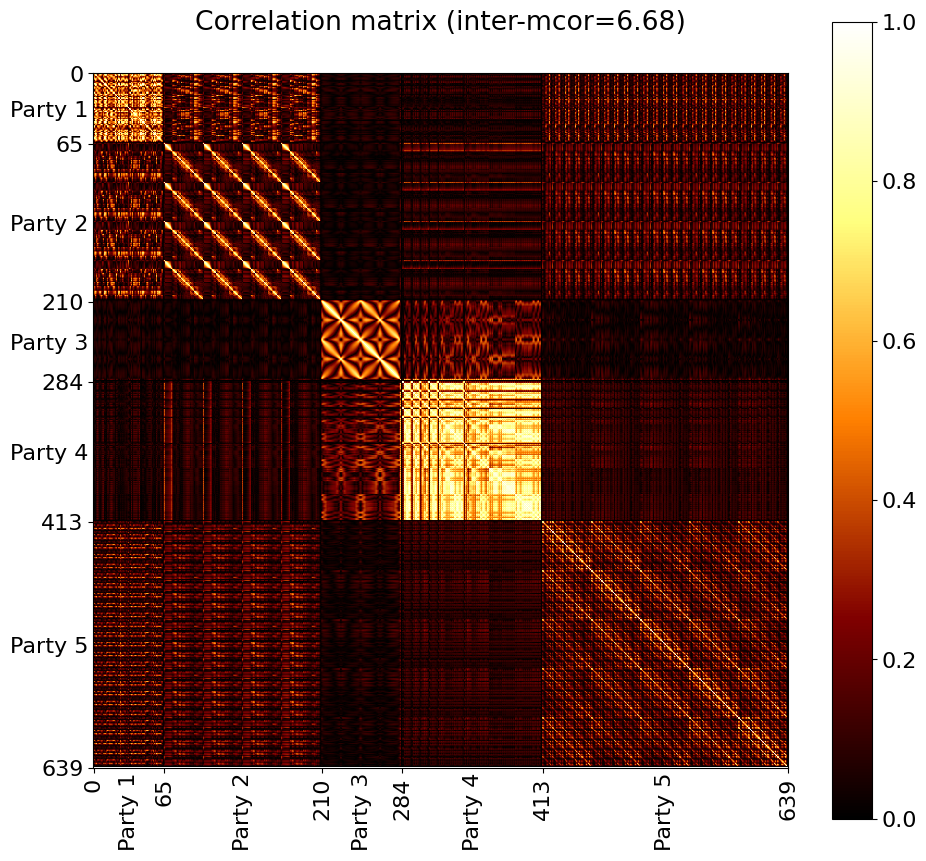

In [15]:
def sigmoid_sharp(x):
    return 1 / (1 + np.exp(-5*x))

corr_evaluator.visualize(value=score, cmap="afmhot")

In [7]:
# vehicle dataset
X, y = load_svmlight_file("data/real/vehicle/processed/vehicle.libsvm")
X = X.toarray()

Xs = [X[:, :50], X[:, 50:]]
evaluator = CorrelationEvaluator(gpu_id=0)
score = evaluator.fit_evaluate(Xs)
print(score)

CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.81s
0.3144468069076538


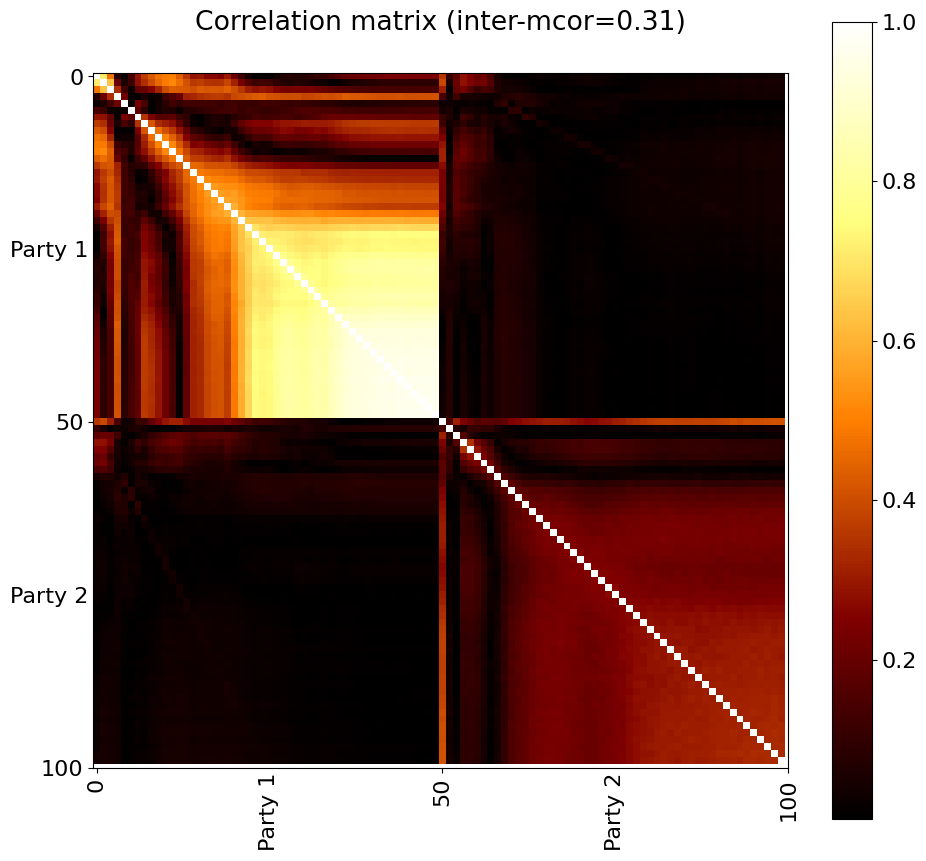

In [8]:
evaluator.visualize(value=score, cmap="afmhot")

In [16]:
from dataset.SatelliteDataset import SatelliteDataset

# satellite dataset
sample_size = 1000
satellite = SatelliteDataset("data/real/satellite/clean")
X, _ = satellite.sample(sample_size, n_jobs=10)
X.shape, y.shape

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:28<00:00,  1.34it/s]


(torch.Size([1000, 16, 13, 158, 158]), (78823,))

In [17]:
import torch
n_parties = 16
X_flatten = X[:, :n_parties, :, :, :].reshape(sample_size, n_parties, -1).permute(1, 0, 2)

n_features = 500
indices = torch.randperm(X_flatten.shape[2])[:n_features]
sampled_X_flatten = X_flatten[:, :, indices]
sampled_X_flatten.shape

torch.Size([16, 1000, 500])

In [18]:
from preprocess.FeatureEvaluator import CorrelationEvaluator

evaluator = CorrelationEvaluator(gpu_id=0)
score = evaluator.fit_evaluate(sampled_X_flatten)
print(score)

CorrelationEvaluator uses cuda:0
Correlation calculation time: 14.18s
6.659353490670522


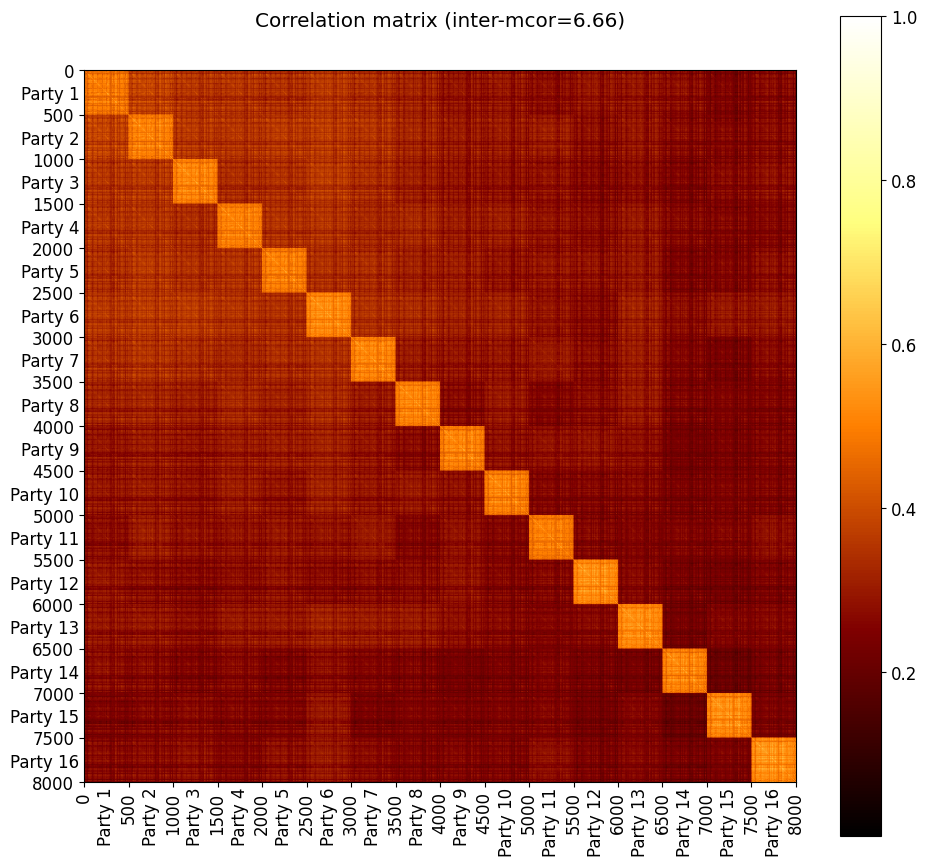

In [19]:
evaluator.visualize(value=score, fontsize=12, cmap="afmhot")

In [20]:
# auto-reload modules when changed
from src.preprocess.FeatureSplitter import ImportanceSplitter
import numpy as np

X = np.zeros([2, 6000])

splitter = ImportanceSplitter(num_parties=4, weights=0.1)
Xs = splitter.split(X, allow_empty_party=False)
print(f"Size of Xs: {[X.shape for X in Xs]}")

Size of Xs: [(2, 5997), (2, 1), (2, 1), (2, 1)]
